# Удаление периодических шумов с изображений
В данной работе рассмотрен способ удаления периодических помех ("сетки") с изображений.  
Для начала импортируем все необходимые библиотеки и функции.

In [1]:
%matplotlib inline
from reader import xcr_reader
import grapher
from analysis.statistics import autocorrelation, crosscorrelation
from analysis import FT, impulse_response
from analysis.preprocessing import BSF
import numpy as np

Импортируем изображение и покажем, что на изображении присутствуют помехи.

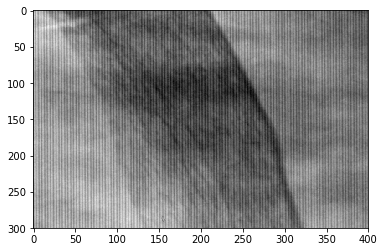

In [2]:
str_path = "data/xray/h400x300.xcr"
cols, rows, depth, image_data = xcr_reader(str_path, 300, 400)
grapher.set_image(image_data, cmap="gray")
grapher.show()

Далее возьмем некую строку изображения и вычислим по ней первую производную (разницу соседних элементов)

In [3]:
N = image_data.shape[0] // 2
derivative = [image_data[N, i + 1] - image_data[N, i] for i in range(len(image_data[N]) - 1)]

После чего применим автокорреляцию для нахождения периодических зависимостей.

In [4]:
ac = [autocorrelation(derivative, i) for i in range(len(derivative))]

Далее к полученным данным применим преобразование Фурье дабы найти необходимую нам частоту.

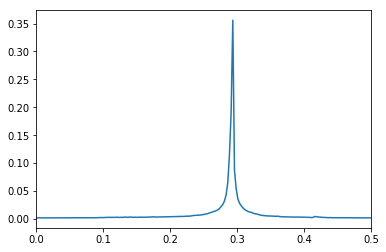

In [5]:
res = FT.fourier_transform(ac, 1)
grapher.set_subplot(1,
                    y_arr=res.frequencies,
                    x_arr=[i * res.deltaF for i in range(len(res.frequencies))],
                    xmin=0, xmax=res.borderF,
                    subplot_x_number=1, subplot_y_number=1, figure_number=12)
grapher.show()

Аналогичный график можно получить, посчитав кросскорреляцию по двум любым строкам изображения.

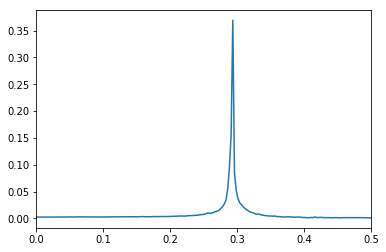

In [6]:
N = image_data.shape[0] // 3
derivative1 = [image_data[N, i + 1] - image_data[N, i] for i in range(len(image_data[N]) - 1)]
N = image_data.shape[0] * 2 // 3
derivative2 = [image_data[N, i + 1] - image_data[N, i] for i in range(len(image_data[N]) - 1)]
cc = [crosscorrelation(derivative1, derivative2, i) for i in range(len(derivative1))]
res2 = FT.fourier_transform(cc, 1)
grapher.set_subplot(1,
                    y_arr=res2.frequencies,
                    x_arr=[i * res2.deltaF for i in range(len(res2.frequencies))],
                    xmin=0, xmax=res2.borderF,
                    subplot_x_number=1, subplot_y_number=1, figure_number=13)
grapher.show()

Можно заметить наличие хорошо различимого пика на графиках. Найдем его местоположение и границы.  
Для этого посчитаем среднее значение по массиву и среднеквадратичное отклонение, и выберем те индексы, по которым значение массива больше, чем среднее + среднеквадратичное отклонение / 4 (делитель необходим для более широких границ и применения менее точного фильтра)

In [7]:
from analysis.statistics import sqrt_variance, mean
d = res.frequencies[:len(res.frequencies) // 2]
m = mean(d)
sqv = sqrt_variance(d)
peaks = [i * res.deltaF for i in range(len(d)) if d[i] > m + sqv / 4]
leftBorder, rightBorder = min(peaks), max(peaks)
print(leftBorder, rightBorder)

0.2731829573934837 0.3107769423558897


Далее создадим band-stop фильтр и применим его к изображению построчно

In [10]:
m = 64
bsfilter = BSF(leftBorder, rightBorder, 1, m)
new_image = np.empty_like(image_data)
for i in range(len(image_data)):
	row = impulse_response.process(image_data[i], bsfilter)
	new_image[i] = row[m:-m - 1]

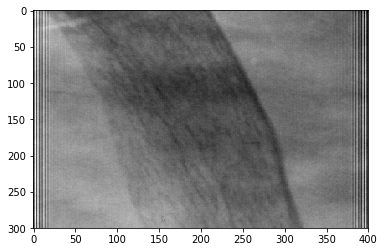

In [11]:
grapher.set_image(new_image, cmap="gray")
grapher.show()

Как можно заметить, с изображения была удалена периодическая структура, оставив лишь краевые эффекты.  
Оформим получившийся код в функцию и продемонстрируем его работу на другом изображении

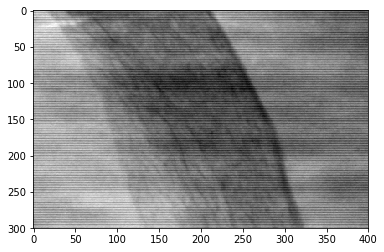

In [12]:
from analysis.preprocessing import remove_periodic
str_path = "data/xray/v400x300.xcr"
cols, rows, depth, image_data = xcr_reader(str_path, 300, 400)
grapher.set_image(image_data, cmap="gray")
grapher.show()

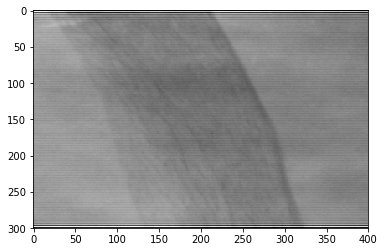

In [14]:
new_image = remove_periodic(image_data, True)
grapher.set_image(new_image, cmap="gray")
grapher.show()